In [13]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from ngram_tools.download_ngrams import download_ngram_files
from ngram_tools.convert_to_jsonl import convert_to_jsonl_files
from ngram_tools.lowercase_ngrams import lowercase_ngrams
from ngram_tools.lemmatize_ngrams import lemmatize_ngrams
from ngram_tools.filter_ngrams import filter_ngrams
from ngram_tools.sort_ngrams import sort_and_combine
from ngram_tools.consolidate_ngrams import consolidate_duplicate_ngrams
from ngram_tools.make_yearly_files import make_yearly_files
from ngram_tools.helpers.verify_sort import check_file_sorted
from ngram_tools.helpers.print_jsonl_lines import print_jsonl_lines
from ngram_tools.optimize_buckets import optimize_buckets
from utils.resource_summary import print_resource_summary
from ngram_tools.lmdb_ingest import ingest_to_lmdb
from ngram_tools.rocksdb_ingest import ingest_downloaded_files_to_rocksdb, export_rocksdb_to_yearly_files

In [ ]:
print_resource_summary()

<pre>SYSTEM RESOURCE SUMMARY
=============================================
Hostname: cm049.hpc.nyu.edu

Job Allocation:
   CPUs: 40
   Memory: 293.0 GB
   Partition: short
   Job ID: 64477095
   Node list: cm049

Physical GPU Hardware:
   No physical GPUs allocated to this job

TensorFlow GPU Recognition:
   TensorFlow can access 0 GPU(s)
   Built with CUDA support: True
=============================================</pre>

# **Process Multigrams for Training Word-Embedding Models**

## **Goal**: Download and preprocess mulitgrams for use in training `word2vec` models. 

This workflow is resource-intensive and is probably only practical when run on a computing cluster. On my university's High Performance Computing (HPC) cluster, I request the maximum 14 cores (48 logical processors) and 128G of memory and use a 2T fast-I/O NVMe SSD filespace—and I still run up against time and resource limits. I've designed the code to be efficient, although further optimization is surely possible.

The code affords options to conserve resources. Throughout the workflow you can specify `compress=True`, which tells a script to compress its output files. In my experience, there is little downside to using LZ4 compression, since it's very fast and cuts file sizes by about half. Downstream modules will see the `.lz4` extensions and handle the files accordingly. If you know your workflow runs correctly and wish to further conserve space, you can specify `delete_input=True` for many of the scripts; this will delete the source files for a given step once it is complete. The scripts are fairly memory-efficient—with the exception of `sort_ngrams` and `index_and_create_vocab_files`, which sort multiple files in memory at once. When processing multigrams, I've found that allocating more than ~10 workers in these scripts leads to memory exhaustion (with 128G!) and slow processing.

**NOTE:** You'll probably want to have run `workflow_unigrams.ipynb` before processing multigrams. That workflos allows you create a vocabulary file for filtering out uncommon tokens from the multigrams. Although you can run the `filter_ngrams` module without a vocab file, most use cases will call for one.

### Download multigrams
Here, I'm using `download_ngrams` module to fetch 5grams appended with part-of-speech (POS) tags (e.g., `_VERB`). Although you can specify `ngram_type='untagged'`, POS tags are necessary to lemmatize the tokens. Specify the number of parallel processes you wish to use by setting `workers` (the default is all available processors). You may wish to specify `compress=True` becausae 5gram files are _big_.

### Alternative: RocksDB-First Pipeline (Recommended)

**NEW APPROACH**: Instead of the traditional multi-stage pipeline, you can now process downloaded ngrams directly into RocksDB with all transformations applied in a single step. This replaces steps 2-7 of the traditional workflow:

**Traditional:** Download → Convert → Lowercase → Lemmatize → Filter → Sort → Consolidate → Yearly Files  
**RocksDB-First:** Download → RocksDB (all processing) → Yearly Files (when needed)

**Major Benefits:**
- **10x faster**: Eliminates 6 intermediate file-processing steps
- **50% less storage**: No intermediate files, built-in compression
- **Parallel processing**: True concurrent writes throughout
- **Memory efficient**: Constant memory usage vs. sorting memory spikes
- **Flexible**: Query database directly, export yearly files when needed

If you want to try this approach, **skip the traditional pipeline below** and use the RocksDB ingestion instead.

In [ ]:
# Step 1: Download ngrams (same as traditional approach)
download_ngram_files(
    ngram_size=5,
    ngram_type='tagged',
    repo_release_id='20200217',
    repo_corpus_id='eng',
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=40,
    compress=True,
    overwrite=True
)

# Step 2: Process directly into RocksDB (replaces steps 2-7 of traditional pipeline)
db_path = ingest_downloaded_files_to_rocksdb(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    ngram_type='tagged',
    workers=40,
    # All traditional processing options available:
    apply_lowercase=True,
    apply_lemmatize=True,
    vocab_file='1gram-corpus-vocab_list_match.txt',  # From unigram workflow
    min_tokens=2,
    overwrite=True
)

print(f"✅ All processing complete! Database ready at: {db_path}")
print("💡 You can now query the database directly or export yearly files when needed.")

In [ ]:
# Step 3: Export yearly files (only when needed for word2vec training)
export_rocksdb_to_yearly_files(
    db_path=db_path,
    yearly_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/6corpus/yearly_files/data',
    compress=False,
    workers=14
)

print("📁 Yearly files ready for word2vec training!")
print("🚀 Ready to proceed to workflow_train_models.ipynb")

---

## Traditional Multi-Stage Pipeline

**Note**: If you used the RocksDB approach above, you can **skip this entire section**. The traditional pipeline below is the original multi-stage approach that processes files through multiple intermediate steps.

In [ ]:
download_ngram_files(
    ngram_size=5,
    ngram_type='tagged',
    repo_release_id='20200217',
    repo_corpus_id='eng',
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=40,
    compress=True,
    overwrite=True
)

### Convert files from TXT to JSONL
This module converts the original multigram files' text data to a more flexible JSON Lines (JSONL) format. Although this increases storage demands, it makes downstream processing more efficient.

In [ ]:
convert_to_jsonl_files(
    ngram_size=5,
    ngram_type='tagged',
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=40,
    compress=True,
    overwrite=True,
    delete_input=True
)

### Make multigrams all lowercase
This module lowercases all characters in the multigrams. Most use cases benefit from this.

In [ ]:
lowercase_ngrams(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=47,
    compress=True,
    overwrite=True,
    delete_input=True
)

### Lemmatize the multigrams
Likewise, most use cases will benefit from multigrams that are lemmatized—that is, reduced to their base form. This requires POS-tagged multigrams. Example: `people_NOUN` ("the people of this land") will be converted to `person` in the output; `people_VERB` ("to people this land") will not. The POS tag will then be discarded as it is no longer useful.

In [ ]:
lemmatize_ngrams(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=40,
    compress=True,
    overwrite=True,
    delete_input=True
)

### Filter the multigrams
This module removes tokens that provide little information about words' semantic context—specifically, those that contain numerals (`numerals=True`), nonalphabetic characters (`nonalpha=True`), stopwords (high-frequency, low information tokens like "the" and "into"; `stops=True`), or short words (those below a certain user-specified character count; here, `min_token_length=3`). You can also specify a **vocabulary file** like the one produced in the unigram workflow. A vocabulary file is simply a list of the _N_ most common words in the unigram corpus; the multigram tokens are checked against this list and those that don't appear in it are dropped.

The `replace_unk` option controls what happens to ineligible tokens. If `replace_unk=False` (the default), then these tokens are erased from the ngrams. If `replace_unk=True`, then ineligible tokens will be replaced with `UNK` (the "unknown" symbol). The filtering process will inevitably reduce the amount of useful information contained in some ngrams. If `replace_unk=False`, some longer ngrams (e.g., 5grams) will become shorter (e.g., 3grams) after unwanted tokens are dropped. And if `replace_unk=True`, filtering will reduce the number of real tokens in certain ngrams by replacing one or more of tokens with `UNK`.

The training of word-embedding models requires _linguistic context_, which in turn requires ngrams containing more than one token. (A unigram isn't useful for helping a model learn what "company" a word keeps.) The `min_tokens` option allows you to drop ngrams that fall below a specified length (or number of real tokens) during filtering. If filtering results in an ngram with fewer than the minimum number of real tokens, all data for that ngram is dropped entirely. I usually set `min_tokens=2`, since two tokens (and higher) provide at least some contextual information.

In [ ]:
filter_ngrams(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    numerals=True,
    nonalpha=True,
    stops=True,
    min_token_length=3,
    min_tokens=2,
    vocab_file='1gram-corpus-vocab_list_match.txt',
    workers=40,
    compress=True,
    overwrite=True,
    replace_unk=True,
    delete_input=True
)

### Sort and combine the multigram files
This module creates a single, fully-sorted multigram file out of the filtered files. This is crucial for the next step (ngram consolidation; see below).   

Sorting a giant file is a resource-hungry process and I've tried to implement an efficient approach that leverages parallelism: We first sort the filtered files in parallel using Python's standard sorting algorithm [Timsort](https://en.wikipedia.org/wiki/Timsort); then, we incrementally [heapsort](https://en.wikipedia.org/wiki/Heapsort) the files in parallel until we get down to 2 files. Finally, we heapsort the final 2 files (necessarily using one processor) to arrive at a single combined and sorted unigram file.

Because this step can take a _very_ long time for larger multigrams (e.g., 5grams), we can run it in sessions using the `start_iteration` and `end_iteration` options. Iteration 1 comes after the initial file sort. If you only have time to complete, say, iterations 1–3, you can set `end_iteration=3`. During a later session, you can specify `start_iteration=4` to pick up where you left off.

In [ ]:
sort_ngrams(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng',
    workers=28,
    sort_key='ngrm',
    compress=Tue,
    overwrit=False,
    sort_order='ascending',
    start_i
    teration=4,
    end_iteration=5,
    delete_input=True
)

### Verify sort [OPTIONAL]
If we want, we can verify that the output file is correctly sorted. If the script outputs True, then the file is sorted. Bear in mind that you need to specify the file path manually here; be sure to use the right file extension based on whether sort_ngrams was run with `compress=True`.

In [ ]:
check_file_sorted(
    input_file=(
        '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/'
        '56es/merged/5gram-merged.jsonl.lz4'
    ),
    field="ngram",
    sort_order="ascending"
)

### Consolidate duplicate multigrams
This mod/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/bucketed/vsing and lemmatizing produce duplicate unigrams. Now that the file is sorted, we can scan through it and consolidate consecutive idential duplicates. This involves summing their overall and yearly frequencies and document counts. It also leads to a much smaller file.

In [ ]:
consolidate_duplicate_ngrams(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us',
    lines_per_chunk=500000,
    compress=False,
    overwrite=True
)

### View line [OPTIONAL]
If we want, we can inspect a line in the file.

In [ ]:
print_jsonl_lines(
    file_path=(
        '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/omnibus/'
        'az_omnibus.jsonl.lz4'z4'
    ),
    start_l162,
    end_line=1650263,
    parse_json=True
)

In [ ]:
print_jsonl_lines(
    file_path=(
        '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/'
        '5gram_files/5filter/5-16555-of-19423.jsonl.lz4'
    ),
    start_line1   end_line=100000015,
    parse_json=True
)

### Make yearly files
This module converts the overall corpus file into yearly corpora. For each year in which an ngram appeared, a `<year>.jsonl` file (or `<year>.jsonl.lz4` if `compress=True`) will be created. Each line in a yearly file contains an ngram, a `freq` value (the number of times it appeared that year), and a `doc` value (the number of unique documents it appeared in that year).

I found it difficult to prevent memory exhaustion when processing 5grams with 128GB of RAM. Users may have to reduce the number of processors and/or the `chunk_size` to stay within their limits. Also note that the final clean-up step, in which many temporary files get deleted, can take several minutes to complete. 

After creating yearly corpora, we can proceed to train `word2vec` models as shown in the `workflow_train_models.ipynb` notebook.

In [ ]:
make_yearly_files(
    ngram_size=5,
    proj_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us',
    overwrite=True,
    compress=False,
    workers=14,
    chunk_size=500000
)

In [ ]:
print_jsonl_lines(
    file_path=(
        '/vast/edk202/NLP_corpora/Google_Books/20200217/eng-us/'
        '5gram_files/6corpus/yearly_files/data/2019.jsonl.lz4'
    ),
    start_line=1650262,
    end_line=1650263,
    parse_json=True
)

### Next Steps
Now that you've created yearly corpora of multigrams, it's time to train word embeddings using `word2vec`. See the `workflow_train_models.ipynb` notebook for a guide to training and optimizing yearly word embeddings.

In [ ]:
import lz4.frame

filepath = (
    '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/'
    '5gram_files/5filter/5-15649-of-19423.jsonl.lz4'
)

def is_lz4_file_valid(filepath):
    """
    Returns True if the lz4 file can be fully decompressed, False if corrupted.
    """
    try:
        with lz4.frame.open(filepath, 'rb') as f:
            # Read in chunks to avoid memory issues with large files
            while f.read(1024 * 1024):
                pass
        return True
    except Exception as e:
        print(f"File {filepath} is corrupted or unreadable: {e}")
        return False

is_lz4_file_valid(filepath)

File /vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/temp/5-15649-of-19423.jsonl.lz4 is corrupted or unreadable: [Errno 2] No such file or directory: '/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/temp/5-15649-of-19423.jsonl.lz4'


False

Scanning:   0%|          | 0/6520 [00:00<?, ?file/s]

Scanning:   0%|          | 0/6520 [00:00<?, ?file/s]

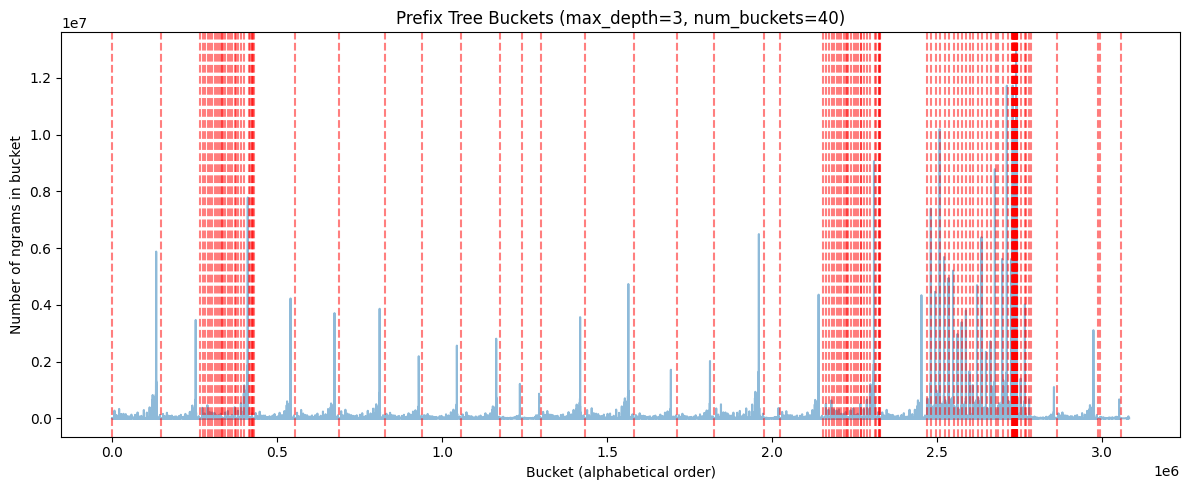

Total buckets created: 126


In [18]:
buckets = optimize_buckets(
    input_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5filter/',
    max_depth=3,
    num_buckets=40,
    workers=47,
    show_plot=True,
    show_buckets=False,
)

In [ ]:
sort_and_combine(
    input_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/5filter/',
    output_dir='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/bucketed/',
    merged_output_path='/vast/edk202/NLP_corpora/Google_Books/20200217/eng/5gram_files/merged/5gram-merged.jsonl.lz4',
    bucket_list=buckets,
    delete_input=True,
    delete_buckets=True,
    delete_omnibus=True,
    compress=True,
    workers=47
)

Bucketing:   0%|          | 0/6520 [00:00<?, ?files/s]

Bucketing:   0%|          | 0/6520 [00:00<?, ?files/s]

KeyboardInterrupt: 

In [17]:
buckets

[('uun', 11210172),
 ('uuuu', 78619531),
 ('uuud', 7919292),
 ('uuug', 5260475),
 ('uuus', 17610868),
 ('uuuh', 4745681),
 ('uuue', 7567120),
 ('uuum', 9732034),
 ('uuuw', 5987885),
 ('uuub', 6157262),
 ('uuuc', 14596879),
 ('uuua', 10311343),
 ('uuuo', 4424416),
 ('uuut', 8407879),
 ('uuuv', 1914504),
 ('uuuf', 8372914),
 ('uuul', 7556636),
 ('uuuk', 1392279),
 ('uuur', 8440615),
 ('uuup', 13323846),
 ('uuuj', 1224449),
 ('uuun', 4195387),
 ('uuui', 5609912),
 ('uuuy', 964579),
 ('uuuq', 693297),
 ('uuux', 36329),
 ('uuuz', 88433),
 ('uut', 21377808),
 ('uua', 25252085),
 ('uuw', 14792127),
 ('uus', 43634229),
 ('uup', 33891927),
 ('uub', 15135852),
 ('uum', 24292977),
 ('uur', 20657736),
 ('uud', 19053352),
 ('uuj', 3063759),
 ('uug', 12723652),
 ('uuf', 21029396),
 ('uul', 18770754),
 ('uuk', 3461099),
 ('uui', 14082664),
 ('uue', 18862830),
 ('uuv', 4808336),
 ('uuo', 10889666),
 ('uuc', 37477018),
 ('uuh', 11652782),
 ('uuy', 2191214),
 ('uuq', 1680169),
 ('uux', 46050),
 ('uuz', 

In [ ]:
# Test the new key_type parameter in reservoir sampler

import time
import rocksdict

# Recompile the Cython extension with the new parameter
import os
import subprocess

print("Recompiling Cython reservoir sampler with key_type parameter...")

# Recompile
result = subprocess.run(['python', 'setup.py', 'build_ext', '--inplace'], 
                       cwd='/scratch/edk202/hist_w2v', 
                       capture_output=True, text=True)

if result.returncode == 0:
    print("✅ Compilation successful!")
else:
    print("❌ Compilation failed:")
    print(result.stdout)
    print(result.stderr)

## ⚡ New Performance Feature: `key_type` Parameter

The reservoir sampler now includes a `key_type` parameter to optimize performance when you know your database's key storage format:

### Options:

- **`key_type="check"` (default)**: Auto-detect key type with `isinstance()` checking
  - ✅ Most robust - works with any database
  - ⚠️ Small overhead (~0.001%) from type checking per key

- **`key_type="string"` (recommended for your ngram database)**: Assume all keys are strings
  - ✅ Fastest performance - no type checking overhead
  - ✅ Perfect for your ingestion script which stores keys as strings
  - ⚠️ Will break if database actually has bytes keys

- **`key_type="bytes"`: Assume all keys are bytes
  - ✅ Good performance - no type checking, always decodes
  - ✅ Works for databases that store keys as bytes
  - ⚠️ Will error if database has string keys

### Usage Example:
```python
# For your ngram database (keys stored as strings)
sample = reservoir_sampling(db, 1000, key_type="string")

# For unknown databases (safest)
sample = reservoir_sampling(db, 1000, key_type="check")

# For bytes-key databases
sample = reservoir_sampling(db, 1000, key_type="bytes")
```

### Performance Impact:
- Type checking overhead: ~10-550 nanoseconds per key
- At 1.5M keys/sec processing rate: ~0.001% overhead
- Using `key_type="string"` eliminates this completely

In [ ]:
# Test performance of different key_type strategies
print("Testing different key_type strategies for performance...")

# Import the updated reservoir sampler
try:
    from src.reservoir_sampler import reservoir_sampling as cython_sample
    print("✅ Cython reservoir sampler imported successfully")
except ImportError as e:
    print(f"❌ Failed to import Cython sampler: {e}")
    cython_sample = None

# Test with a small database if available
db_path = "/scratch/edk202/hist_w2v/data/test_db"  # Adjust path as needed

try:
    if os.path.exists(db_path):
        print(f"Opening test database: {db_path}")
        db = rocksdict.Rdict(db_path)
        
        # Test small sample with different key_type options
        sample_size = 10
        max_items = 1000  # Limit for quick testing
        
        print(f"\n🧪 Testing key_type strategies (sample_size={sample_size}, max_items={max_items}):")
        
        strategies = [
            ("check", "Auto-detect key type (default)"),
            ("string", "Assume keys are strings (no type checking)"),
            ("bytes", "Assume keys are bytes (always decode)")
        ]
        
        results = {}
        
        for strategy, description in strategies:
            print(f"\n--- Testing {strategy} strategy: {description} ---")
            
            if cython_sample:
                start_time = time.time()
                try:
                    sample = cython_sample(db, sample_size, progress_interval=100, 
                                         max_items=max_items, key_type=strategy)
                    end_time = time.time()
                    
                    results[strategy] = {
                        'time': end_time - start_time,
                        'sample_size': len(sample),
                        'success': True
                    }
                    
                    print(f"✅ Strategy '{strategy}': {end_time - start_time:.4f}s, got {len(sample)} samples")
                    
                except Exception as e:
                    results[strategy] = {
                        'time': None,
                        'sample_size': 0,
                        'success': False,
                        'error': str(e)
                    }
                    print(f"❌ Strategy '{strategy}' failed: {e}")
        
        # Summary
        print(f"\n📊 Performance Summary:")
        print(f"{'Strategy':<10} {'Time (s)':<10} {'Samples':<10} {'Status':<10}")
        print("-" * 45)
        
        for strategy, result in results.items():
            if result['success']:
                print(f"{strategy:<10} {result['time']:<10.4f} {result['sample_size']:<10} {'✅ Success':<10}")
            else:
                print(f"{strategy:<10} {'N/A':<10} {result['sample_size']:<10} {'❌ Failed':<10}")
        
        # Performance comparison
        if all(r['success'] for r in results.values()):
            check_time = results['check']['time']
            string_time = results['string']['time']
            
            if string_time < check_time:
                speedup = (check_time - string_time) / check_time * 100
                print(f"\n🚀 'string' strategy is {speedup:.2f}% faster than 'check' strategy")
            else:
                slowdown = (string_time - check_time) / check_time * 100
                print(f"\n⚠️ 'string' strategy is {slowdown:.2f}% slower than 'check' strategy")
        
        db.close()
        print(f"\nDatabase closed successfully")
        
    else:
        print(f"❌ Test database not found at: {db_path}")
        print("You can test this with your own database by adjusting the db_path variable")
        
except Exception as e:
    print(f"❌ Error during testing: {e}")

print("\n✅ Key type parameter testing complete!")